# A simple Rubik's Cube Stimulation


In [1]:
import numpy as np
import colorama as col
from random import randint, choice

cols = [
    col.Back.RESET,
    col.Back.WHITE,
    col.Back.BLUE,
    col.Back.MAGENTA,
    col.Back.YELLOW,
    col.Back.GREEN,
    col.Back.RED,
]


class MagicCube:
    def __init__(self, vis_bais=0):
        self.state = np.array([[i + 1] * 9 for i in range(6)], dtype=np.int32)
        self.vis_bais = vis_bais
        self.log = None
        # fmt:off
        self.action = {
            "R" : (1, 0),
            "R'": (1, 1),
            "U" : (0, 0),
            "U'": (0, 1),
            "L" : (4, 0),
            "L'": (4, 1),
            "D" : (3, 0),
            "D'": (3, 1),
            "F" : (5, 0),
            "F'": (5, 1),
        }
        # fmt:on

    def rotate(self, i, dir=0):
        def move(l, offset):
            return tuple(l[(i - offset) % len(l)].copy() for i in range(len(l)))

        i_ = (
            ((i - 2) % 6, [2, 5, 8]),
            ((i - 1) % 6, [6, 7, 8]),
            ((i + 1) % 6, [0, 3, 6]),
            ((i + 2) % 6, [0, 1, 2]),
        )
        t = ((i % 2 + dir) % 2) * 2 - 1

        (
            self.state[i_[0]],
            self.state[i_[1]],
            self.state[i_[2]],
            self.state[i_[3]],
        ) = move([self.state[i] for i in i_], t)

        self.state[i] = np.rot90(self.state[i].reshape((3, 3)), t).reshape(-1)

    def face(self, i):
        i = (i + self.vis_bais) % 6
        if i % 2:
            return self.state[i].reshape((3, 3)).T
        else:
            return self.state[i].reshape((3, 3))

    def vis_face(self, i):
        t = self.face(i)
        for l in range(len(t)):
            print("".join([cols[i] + "  " for i in t[l]]))

    def expansion(self):
        z = np.zeros((3, 3), dtype=np.int32)
        f = [self.face(i) for i in range(6)]
        return np.hstack(
            (
                np.vstack((f[0], f[1], z, z)),
                np.vstack((z, f[2], f[3], z)),
                np.vstack((z, z, f[4], f[5])),
            )
        )

    def vis_expansion(self):
        t = self.expansion()
        for l in range(len(t)):
            print("".join([cols[i] + "  " for i in t[l]]))

    def execute(self, acts):
        if isinstance(acts, str):
            acts = acts.split(" ")
        for i in acts:
            self.rotate(*self.action[i])

    def shuffle(self):
        seq = []
        for i in range(randint(3, 10)):
            seq.append(choice(list(self.action.keys())))
        self.execute(seq)
        return seq


In [51]:
c = MagicCube()
c.rotate(0)
# c.rotate(1)
# c.rotate(2)
# c.execute("U R U' R'")
# seq = c.shuffle()
# print(seq)
c.vis_expansion()

"R2 U R U R' U' R' U' R' U R'"
"R U R U R U R U' R' U' R2"
"M2 U M U2 M' U M2"

cmp = c.state.reshape(-1)


# Experimantal

### Matrix Representation

Since rotation exchanges face state by position, it could use a sparse matrix which generated by swaping rows of 54*54 identity matrix to represent a rotation.


In [24]:
state = np.array([i + 1 for i in range(6) for j in range(9)], dtype=np.int32)


print(np.rot90(np.array(range(9), dtype=np.int32).reshape((3, 3)), -1).reshape(-1))

state

[6 3 0 7 4 1 8 5 2]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [49]:
# face num changed to 1~6
def rotateMat(i):
    i -= 1
    i_ = (
        ((i - 2) % 6, [2, 5, 8]),
        ((i - 1) % 6, [6, 7, 8]),
        ((i + 1) % 6, [0, 3, 6]),
        ((i + 2) % 6, [0, 1, 2]),
    )

    res = np.eye(54, dtype=np.int8)

    g0 = np.array([i[0] * 9 + j for i in i_ for j in i[1]])
    g1 = np.roll(g0, -3)
    
    c0 = [i * 9 + t for t in range(9)]
    c1 = [i * 9 + t for t in [6, 3, 0, 7, 4, 1, 8, 5, 2]]

    # print(g0)
    # print(g1)
    # print(c0)
    # print(c1)

    for x in range(len(g0)):
        res[g0[x]][g0[x]] = 0
        res[g0[x]][g1[x]] = 1

    for x in range(len(c0)):
        res[c0[x]][c0[x]] = 0
        res[c0[x]][c1[x]] = 1

    if i % 2 == 0:
        return res
    else:
        return res.T


# np.set_printoptions(threshold=np.inf)
rotateMat(1)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [67]:
c = MagicCube()

face = 5

c.rotate(0)
c.rotate(1)
c.rotate(2)

t = rotateMat(3) @ rotateMat(2) @ rotateMat(1)

d = np.matmul(t, state)

cmp = c.state.reshape(-1)

(cmp == d).all()


True

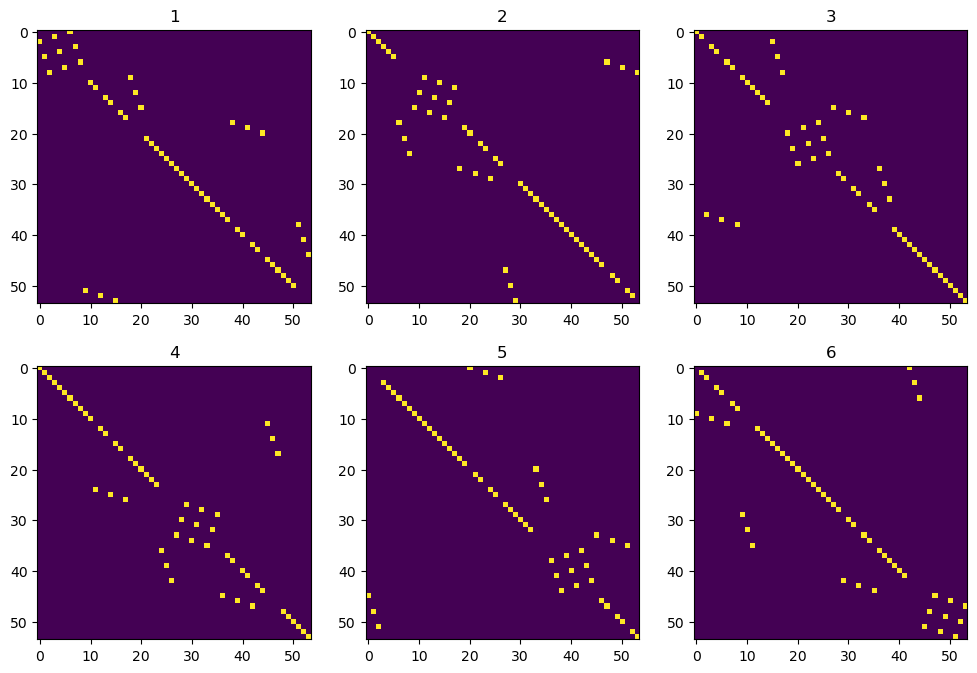

In [36]:
import matplotlib.pyplot as plt


l = [rotateMat(i) for i in range(1, 7)]
l += [i.T for i in l]

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(231 + i)
    plt.title(i + 1)
    plt.imshow(l[i])


In [61]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

k = rotateMat(1)

print((np.roll(k, 18, axis=(0, 1)) == rotateMat(3)).all())
print((np.roll(k, 9, axis=(0, 1)) == rotateMat(2).T).all())
print((k @ k.T == np.eye(54)).all())



True
True
True


In [62]:

mat1 = np.eye(54)

mate = (
    (
        (38, 41, 44, 51, 52, 53, 9, 12, 15, 18, 19, 20),
        (51, 52, 53, 9, 12, 15, 18, 19, 20, 38, 41, 44),
    ),
    ((0, 1, 2, 3, 4, 5, 6, 7, 8), (6, 3, 0, 7, 4, 1, 8, 5, 2)),
)

for l in mate:
    for i in range(len(l[0])):
        mat1[l[0][i]][l[0][i]] = 0
        mat1[l[0][i]][l[1][i]] = 1

(mat1 == rotateMat(1)).all()


mats = [
    np.roll(mat1, 9 * i, axis=(0, 1))
    if i % 2 == 0
    else np.roll(mat1, 9 * i, axis=(0, 1)).T
    for i in range(6)
]


[(mats[i] == rotateMat(i + 1)).all() for i in range(6)]


[True, True, True, True, True, True]

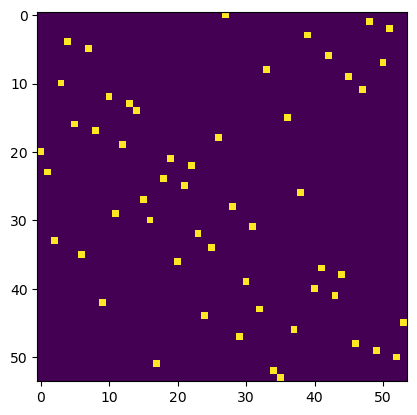

In [77]:
# 3' 2 1
def rotates(l):
    t = np.eye(54)
    for i in l:
        if i < 0:
            t = mats[-i - 1].T @ t
        else:
            t = mats[i - 1] @ t
    return t


t = rotates([-3, 2, 1, -2, -1, -5, 6])

plt.imshow(t)
